## Analyzing Covid statistics 

In [5]:
import pandas as pd
import sqlite3

In [6]:
conn = sqlite3.connect('./data/Covid.db')
curs = conn.cursor()

___
1) Which state(s) were the first to issue a state of emergency, and how many positive test cases had been reported in those state(s) at that time?

Return three columns:
- State
- Number of positive tests
- Date of emergency declaration

In [7]:
pd.read_sql("""SELECT state, positive AS totalPositiveTests, emergencyMonth, emergencyDay
            FROM (SELECT st, state, emergencyMonth, emergencyDay
                FROM tEmergency
                JOIN tState USING(st)
                ORDER BY emergencyMonth, emergencyDay DESC
                LIMIT 1)
            JOIN (SELECT * FROM tTest WHERE month LIKE '2' and day LIKE '29') USING (st);""", conn)

,state,totalPositiveTests,emergencyMonth,emergencyDay
0,Washington,18,2,29


___

2) Of states which did declare a state of emergency, which were the last, how many DEATHS had been reported in those state(s) at that time, and, if they did issue a statewide stay at home order, when?

Return 4 columns:

- State
- Number of deaths at the time state of emergency was declared
- Date the state of emergency was declared
- Date stay-at-home order issued (if it exists)

In [8]:
pd.read_sql("""SELECT st, state, emergencyMonth, emergencyDay
                FROM tEmergency
                JOIN tState USING(st)
                ORDER BY emergencyMonth DESC, emergencyDay DESC
                LIMIT 1;""", conn)

,st,state,emergencyMonth,emergencyDay
0,WV,West Virginia,3,16


In [9]:
pd.read_sql("""SELECT state, deaths, emergencyMonth, emergencyDay, monthAnnounced, dayAnnounced
            FROM (SELECT st, state, emergencyMonth, emergencyDay
                FROM tEmergency
                JOIN tState USING(st)
                ORDER BY emergencyMonth DESC, emergencyDay DESC
                LIMIT 1)
            JOIN (SELECT * FROM tTest WHERE month LIKE '3' and day LIKE '16') USING (st)
            JOIN tHome USING(st)
            GROUP BY state;""", conn)

,state,deaths,emergencyMonth,emergencyDay,monthAnnounced,dayAnnounced
0,West Virginia,0,3,16,3,23


___
3) According to the data provided, which state(s) did not issue a stay-at-home order, and how many total deaths have been reported in those state(s)?

Return two columns:
- State
- Number of deaths (as of Nov 15)

In [10]:
pd.read_sql("""SELECT A.st
            FROM tState AS A
            EXCEPT 
            SELECT B.st
            FROM tHome AS B;""", conn)

,st
0,AR
1,IA
2,ND
3,NE
4,OK
5,SC
6,SD
7,UT
8,WY


In [11]:
pd.read_sql("""SELECT state, deaths 
            FROM (SELECT A.st
                FROM tState AS A
                EXCEPT 
                SELECT B.st
                FROM tHome AS B)
            JOIN tState USING(st)
            JOIN (SELECT st, deaths FROM tTest WHERE month LIKE '11' AND day LIKE '15') USING(st);""", conn)

,state,deaths
0,Arkansas,2183
1,Iowa,1985
2,North Dakota,570
3,Nebraska,779
4,Oklahoma,1528
5,South Carolina,4112
6,South Dakota,644
7,Utah,718
8,Wyoming,144


___
4) Repeat the previous question, but this time look at states that did issue a stay-at-home order

Return three columns:
- State
- Number of deaths (as of Nov 15)
- Date stay-at-home order announced

In [12]:
pd.read_sql("""SELECT DISTINCT state, monthAnnounced, dayAnnounced
            FROM tState
            JOIN tHome USING(st);""", conn)

,state,monthAnnounced,dayAnnounced
0,Alabama,4,3
1,Alaska,3,27
2,Arizona,3,30
3,California,3,19
4,Colorado,3,26
5,Connecticut,3,20
6,Delaware,3,22
7,Florida,4,1
8,Georgia,4,2
9,Hawaii,3,23


In [13]:
pd.read_sql("""SELECT state, deaths, monthAnnounced, dayAnnounced
            FROM (SELECT DISTINCT st, state, monthAnnounced, dayAnnounced
                FROM tState
                JOIN tHome USING(st))
            JOIN (SELECT st, deaths FROM tTest WHERE month LIKE 11 AND day LIKE 15) USING(st);""", conn)

,state,deaths,monthAnnounced,dayAnnounced
0,Alaska,98,3,27
1,Alabama,3248,4,3
2,Arizona,6302,3,30
3,California,18253,3,19
4,Colorado,2234,3,26
5,Connecticut,4737,3,20
6,District of Columbia,660,3,30
7,Delaware,736,3,22
8,Florida,17734,4,1
9,Georgia,8957,4,2


___
5) Return the following statistics for Virginia:
- Total number of postive cases reported
- Total number of deaths
- Total number of deaths per capita
- Mortality rate, estimated by: Number of deaths / number of positive cases


In [14]:
pd.read_sql("""SELECT * 
            FROM tTest
            WHERE st LIKE 'VA'
            ORDER BY month DESC, day DESC
            LIMIT 1;""", conn)

,st,month,day,positive,negative,deaths,posIncrease,negIncrease,deathIncrease,totalTestResults,totalTestRessultsIncrease
0,VA,11,15,201960,2737283,3800,1161,32765,1,2920737,33735


In [15]:
pd.read_sql("""SELECT positive, deaths, cast(deaths as float)/cast(pop2019 as float) AS deathsPerCapita, cast(deaths as float)/cast(positive as float) AS mortalityRate
            FROM (SELECT * 
                FROM tTest
                WHERE st LIKE 'VA'
                ORDER BY month DESC, day DESC
                LIMIT 1)
            JOIN tPop USING(st);""", conn)

,positive,deaths,deathsPerCapita,mortalityRate
0,201960,3800,0.000445,0.018816


___
6) Which state has had the most deaths per capita as of Nov 15?

Return: 

- State
- Number of deaths
- Population
- Population per square mile
- Number of deaths per capita
- Mortality rate, estimated as 


In [16]:
curs.execute("DROP VIEW IF EXISTS vTopDeaths;")
curs.execute("""CREATE VIEW vTopDeaths AS
                SELECT *
                FROM tTest
                WHERE month LIKE '11' AND day LIKE '15';""")

In [17]:
pd.read_sql("""SELECT state, deaths, pop2019, popPerSqMi, cast(deaths as float)/cast(pop2019 as float) AS deathsPerCapita, cast(deaths as float)/cast(positive as float) AS mortalityRate
            FROM vTopDeaths
            JOIN tPop USING(st)
            JOIN tState USING(st);""", conn)

,state,deaths,pop2019,popPerSqMi,deathsPerCapita,mortalityRate
0,Alaska,98,731545,1.281971,0.000134,0.004115
1,Alabama,3248,4903185,96.814158,0.000662,0.014911
2,Arkansas,2183,3017804,57.995122,0.000723,0.016409
3,Arizona,6302,7278717,64.076552,0.000866,0.022880
4,California,18253,39512223,253.642450,0.000462,0.017907
5,Colorado,2234,5758736,55.563788,0.000388,0.014030
6,Connecticut,4737,3565287,736.270538,0.001329,0.053438
7,District of Columbia,660,705749,11560.180180,0.000935,0.034779
8,Delaware,736,973764,499.740318,0.000756,0.025553
9,Florida,17734,21477737,400.519033,0.000826,0.020318


In [18]:
pd.read_sql("""SELECT state, deaths, pop2019, popPerSqMi, deathsPerCapita, mortalityRate
            FROM (SELECT state, deaths, pop2019, popPerSqMi, cast(deaths as float)/cast(pop2019 as float) AS deathsPerCapita, cast(deaths as float)/cast(positive as float) AS mortalityRate
                FROM vTopDeaths
                JOIN tPop USING(st)
                JOIN tState USING(st))
            ORDER BY deathsPerCapita DESC
            LIMIT 1;""", conn)

,state,deaths,pop2019,popPerSqMi,deathsPerCapita,mortalityRate
0,New Jersey,16566,8882190,1207.767785,0.001865,0.059318


___
7) Repeat the previous question, but this time for the state with the fewest deaths per capita as of Nov 15

In [19]:
curs.execute("DROP VIEW IF EXISTS vMinDeaths;")
curs.execute("""CREATE VIEW vMinDeaths AS
                SELECT *
                FROM tTest
                WHERE month LIKE '11' AND day LIKE '15';""")

In [20]:
pd.read_sql("""SELECT state, deaths, pop2019, popPerSqMi, cast(deaths as float)/cast(pop2019 as float) AS deathsPerCapita, cast(deaths as float)/cast(positive as float) AS mortalityRate
            FROM vMinDeaths
            JOIN tPop USING(st)
            JOIN tState USING(st);""", conn)

,state,deaths,pop2019,popPerSqMi,deathsPerCapita,mortalityRate
0,Alaska,98,731545,1.281971,0.000134,0.004115
1,Alabama,3248,4903185,96.814158,0.000662,0.014911
2,Arkansas,2183,3017804,57.995122,0.000723,0.016409
3,Arizona,6302,7278717,64.076552,0.000866,0.022880
4,California,18253,39512223,253.642450,0.000462,0.017907
5,Colorado,2234,5758736,55.563788,0.000388,0.014030
6,Connecticut,4737,3565287,736.270538,0.001329,0.053438
7,District of Columbia,660,705749,11560.180180,0.000935,0.034779
8,Delaware,736,973764,499.740318,0.000756,0.025553
9,Florida,17734,21477737,400.519033,0.000826,0.020318


In [21]:
pd.read_sql("""SELECT state, deaths, pop2019, popPerSqMi,deathsPerCapita, mortalityRate
            FROM (SELECT state, deaths, pop2019, popPerSqMi, cast(deaths as float)/cast(pop2019 as float) AS deathsPerCapita, cast(deaths as float)/cast(positive as float) AS mortalityRate
                FROM vMinDeaths
                JOIN tPop USING(st)
                JOIN tState USING(st))
            ORDER BY deathsPerCapita ASC
            LIMIT 1;""", conn)

,state,deaths,pop2019,popPerSqMi,deathsPerCapita,mortalityRate
0,Vermont,59,623989,67.702291,0.000095,0.020422


___
8) For the entire US (i.e. the sum of all 50 states + Washington DC):

Get the daily number (not the running total) of positive cases, deaths, and tests reported

Return: 

- Date
- The number of new positive tests reported per day
- The number of new deaths reported per day
- The number of new tests performed per day

Order the results by date, ascending

In [22]:
entireUS = pd.read_sql("""SELECT month, day, sum(posIncrease) AS newPos, sum(deathIncrease) AS newDeaths, sum(totalTestRessultsIncrease) AS newTests
            FROM tTest
            GROUP BY month, day
            ORDER BY month ASC, day ASC;""", conn)
entireUS

,month,day,newPos,newDeaths,newTests
0,1,22,0,0,0
1,1,23,0,0,1
2,1,24,0,0,0
3,1,25,0,0,0
4,1,26,0,0,0
...,...,...,...,...,...
294,11,11,144134,1553,1380904
295,11,12,149099,1096,1488194
296,11,13,170051,1297,1682170
297,11,14,162755,1314,1654691


In [23]:
for row in entireUS["newDeaths"]:
    if row <0:
        print(row)


Make a plot with date on the x-axis, and daily # of deaths on the y-axis.


In [24]:
entireUS["date"] = entireUS["month"].astype(str)+ "-" + entireUS["day"].astype(str) +"-2020"
entireUS = entireUS.drop(["month", "day"], axis = 1)

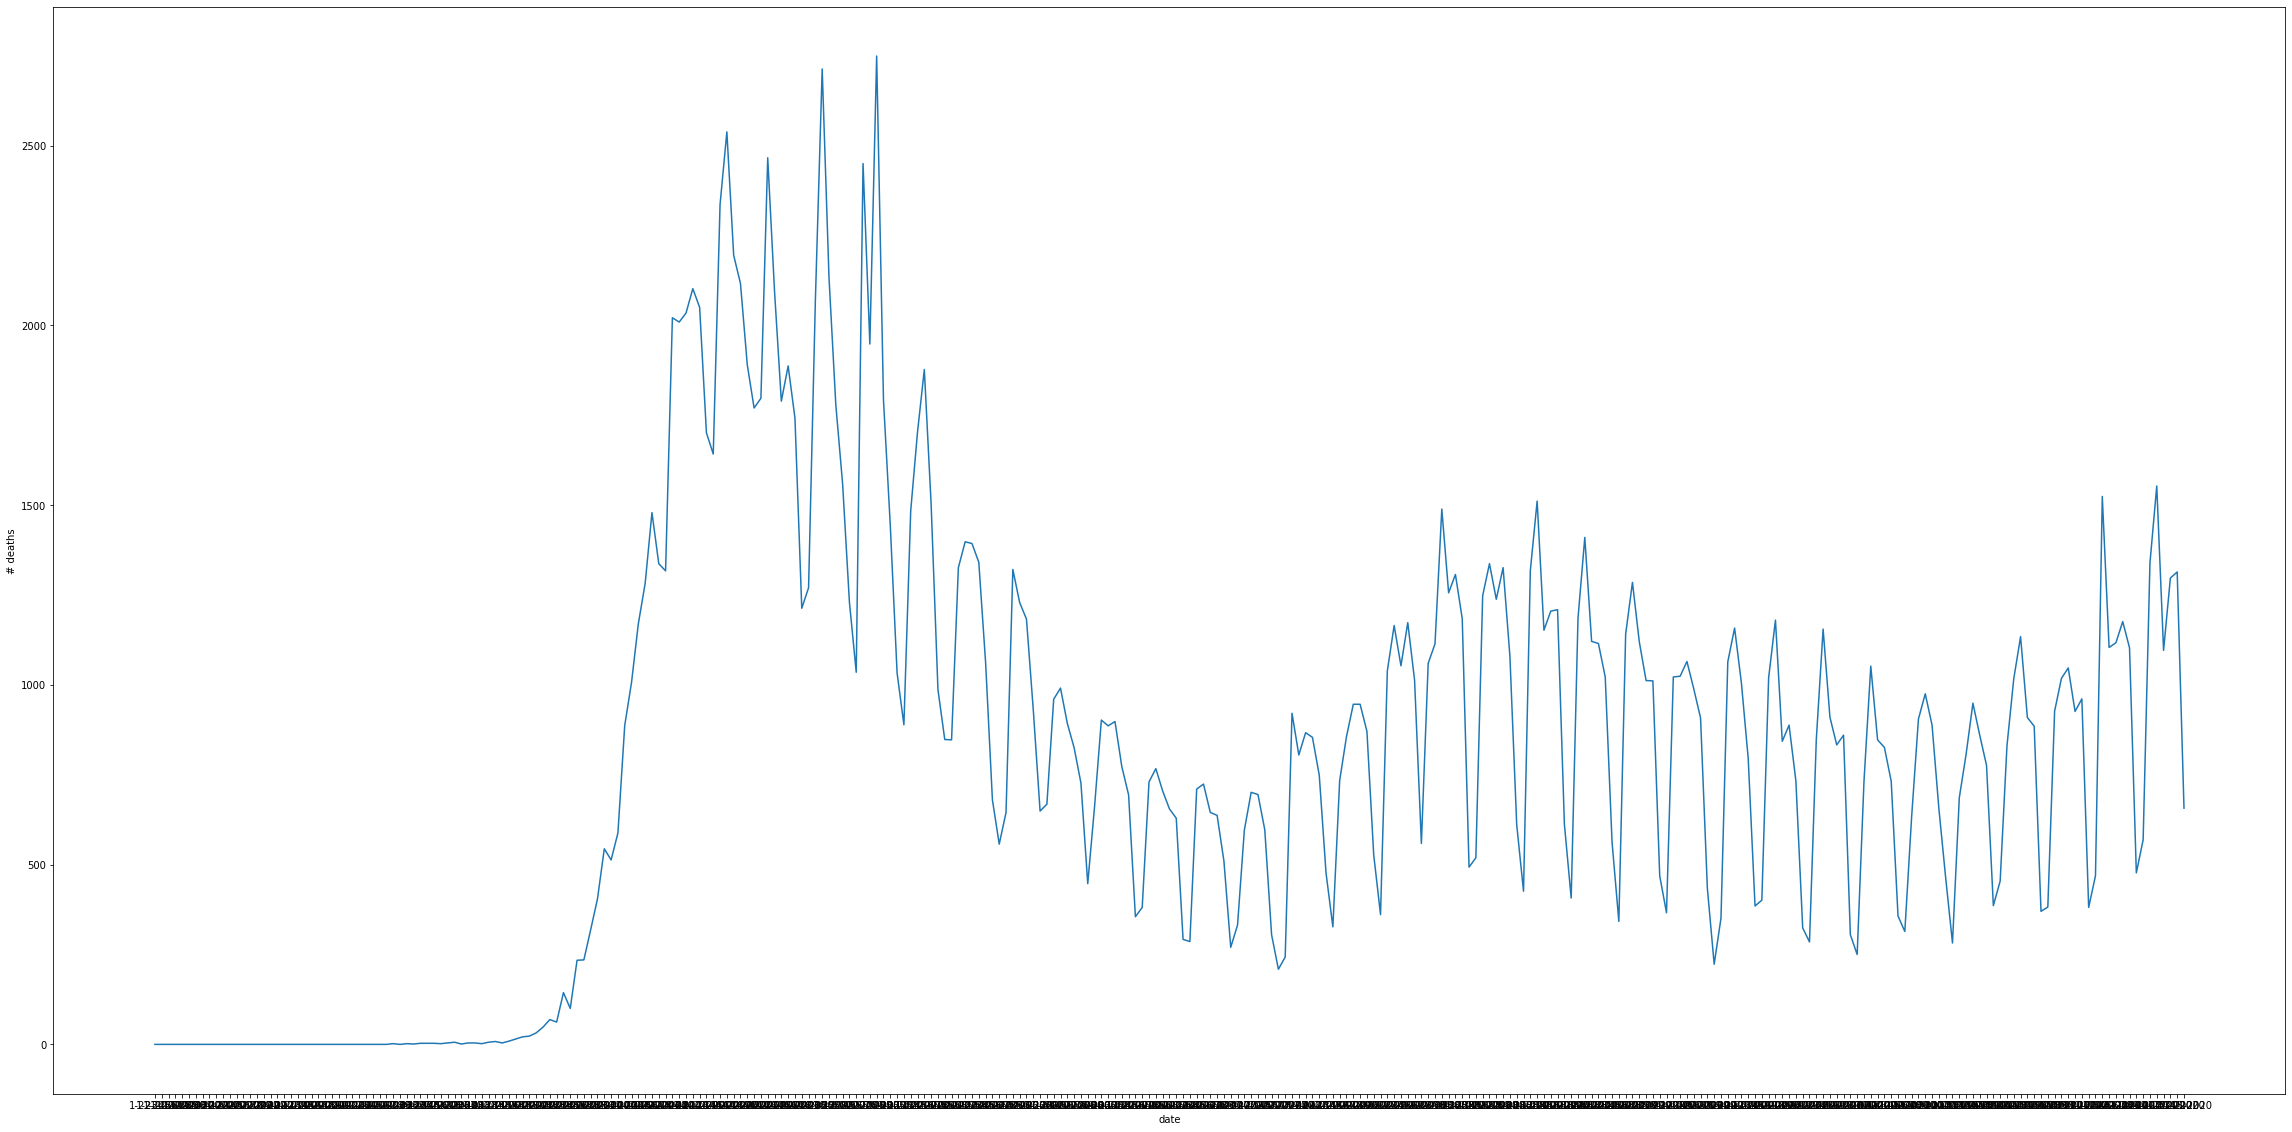

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,20))
plt.plot(entireUS["date"], entireUS["newDeaths"])
plt.ylabel('# deaths')
plt.xlabel('date')
plt.show()

In [26]:
# Don't forget to close the database!
conn.close

<function Connection.close>